In [28]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [29]:
# load data
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
data = pd.read_csv(url)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [30]:
"""
## Data Preprocessing
"""

# Drop Ticket and Passengerid because they are distinct for every passenger
data.drop(['Ticket', 'PassengerId'], axis=1, inplace=True)

# Transfer String data to Number
# Mapping 0 for male and 1 for female
gender_mapper = {'male': 0, 'female': 1}
data['Sex'].replace(gender_mapper, inplace=True)

# Extract Mr, Miss and Mrs from Name
data['Title'] = data['Name'].apply(lambda x: x.split(',')[1].strip().split(' ')[0])
data['Title'] = [0 if x in ['Mr.', 'Miss.', 'Mrs.'] else 1 for x in data['Title']]
data = data.rename(columns={'Title': 'Title_Unusual'})
data.drop('Name', axis=1, inplace=True)

# Detect Cabin_Known whether NaN
# 0 for Nan and 1 for otherwise
data['Cabin_Known'] = [0 if str(x) == 'nan' else 1 for x in data['Cabin']]
data.drop('Cabin', axis=1, inplace=True)

# Embarked is Dummy variable
emb_dummies = pd.get_dummies(data['Embarked'], drop_first=True, prefix='Embarked')
data = pd.concat([data, emb_dummies], axis=1)
data.drop('Embarked', axis=1, inplace=True)

# Fill missing values of Age with mean of Age
data['Age'] = data['Age'].fillna(int(data['Age'].mean()))

In [31]:
# After processing
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Unusual,Cabin_Known,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,0,0,0,1
1,1,1,1,38.0,1,0,71.2833,0,1,0,0
2,1,3,1,26.0,0,0,7.9250,0,0,0,1
3,1,1,1,35.0,1,0,53.1000,0,1,0,1
4,0,3,0,35.0,0,0,8.0500,0,0,0,1


In [32]:
"""
## Removing Correlated Features because they provide the same information 
"""

correlated_features = set()
correlation_matrix = data.drop('Survived', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [33]:
"""
## Running Recursive Feature Elimination with Cross-Validation (RFECV)
"""

X = data.drop('Survived', axis=1)
target = data['Survived']

# using RandomForest
rfc = RandomForestClassifier(random_state=101)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X, target)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(random_state=101), scoring='accuracy')

In [34]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 4


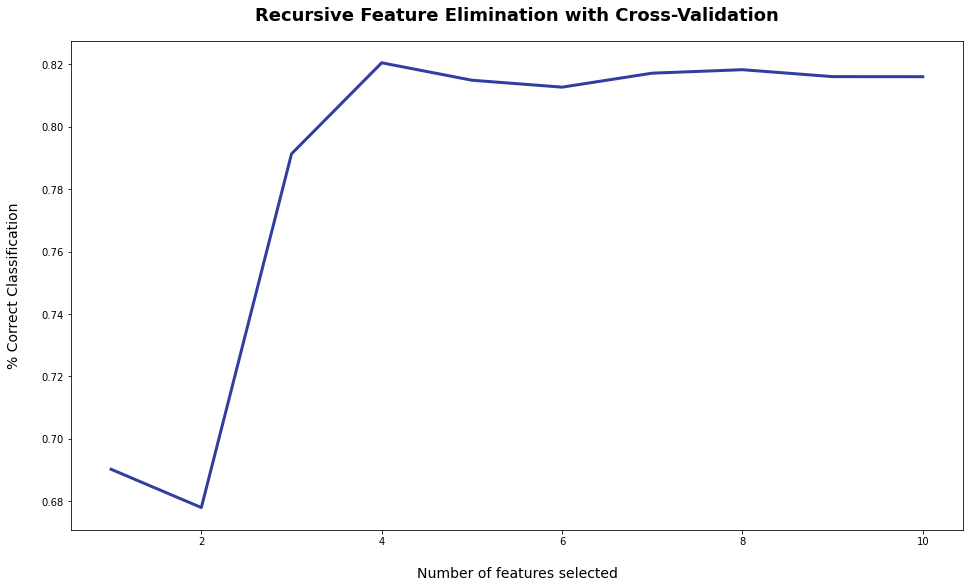

In [35]:
# Result of RFECV

plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
plt.show()

In [36]:
# print out which features are the least important and drop them

print(np.where(rfecv.support_ == False)[0])
X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[3 4 6 7 8 9]


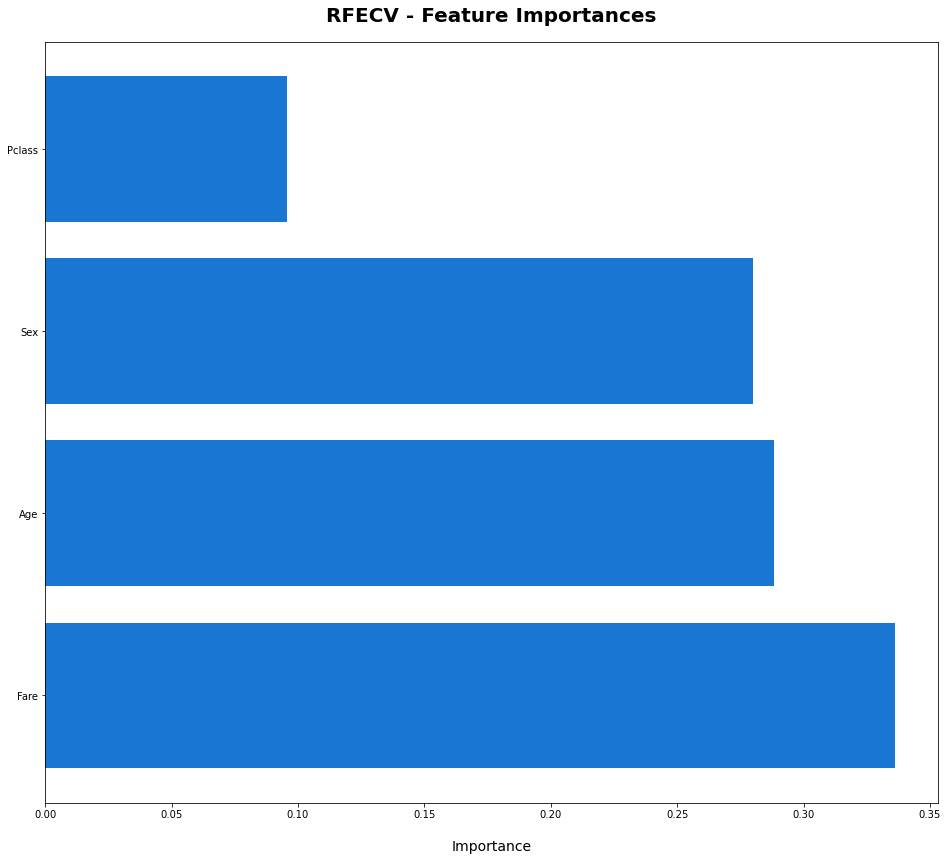

In [16]:
"""
## Result of RFECV ranked by importances
"""

dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()